Коэффициенты линейной аппроксимации сигнала a =  0.0014991434991434992  и b =  424.1366786786787


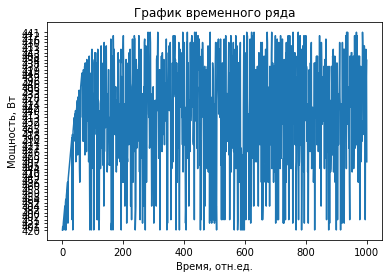

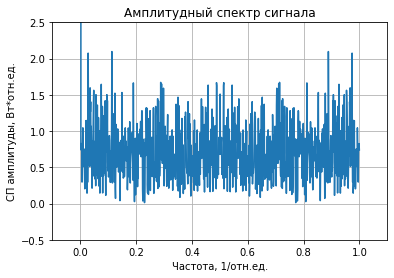

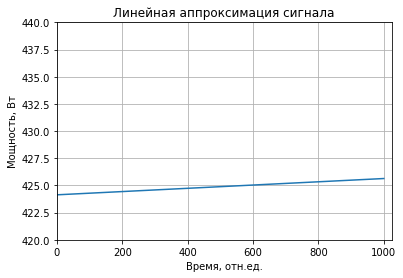

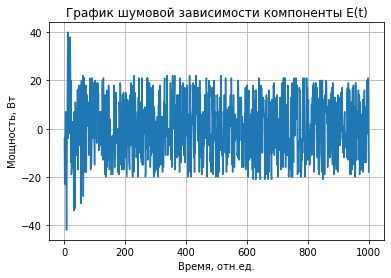

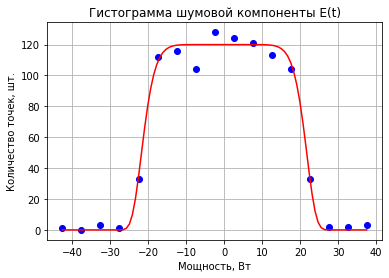

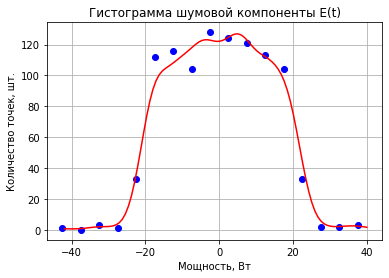

Вероятность, рассчитанная с помощью gaussian_kde() =  0.5778683864485995


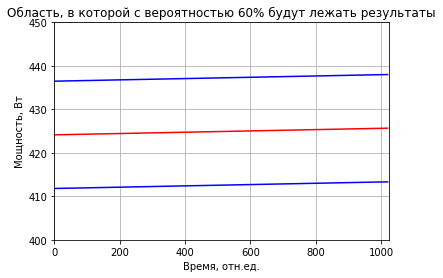

Нормировка плотности вероятности norm =  (5023.1320648970905, 4.6145782093237907e-07) , mean_val =  (0.0, 0.0) 
Стандартное отклонение std =  12.336781072880715 , Вероятность P =  (0.5892738911219244, 1.2707299433404337e-12)


In [6]:
import math
import matplotlib.pyplot as plt  # Подключаем все необходимые модули
import numpy.fft as fft
import scipy.stats as st
import numpy as np
import scipy.integrate as integrate

def init(fileName):  # Инициализация исходных табличных данных
    xlist = []
    ylist = []

    file = open(fileName,'r')  #'Zadacha_RTI_MIET.csv'
    for line in file:
        flag = 0
        for element in line:
            if ((element>='А')and(element<='я')):
                flag = 1
        if (flag == 0):
            index = line.find(';')
            endl = line.find('\n')
            xlist.append(int(line[0:index]))
            ylist.append(line[index+1:endl])
    return [xlist, ylist]  # Функция возвращает массив из двух исходных массивов

def initLinApprox(xylist):  # Инициализация функции линейной аппроксимации сигнала
    xlist = xylist[0]
    ylist = xylist[1]
    sumx = 0
    sumy = 0
    sumx2 = 0
    sumxy = 0
    for i in range(len(xlist)):
        sumx += int(xlist[i])
        sumy += int(ylist[i])
        sumx2 += pow(int(xlist[i]), 2)
        sumxy += int(xlist[i]) * int(ylist[i])
    a = ( len(xlist) * sumxy - sumx * sumy ) / ( len(xlist) * sumx2 - pow(sumx, 2) )
    b = ( sumy - a * sumx ) / ( len(xlist) )
    print("Коэффициенты линейной аппроксимации сигнала a = ", a, " и b = ", b)

    xApprox = []
    yApprox = []
    for i in range(len(xlist)):
        xApprox.append(xlist[i])
        yApprox.append(a * int(xlist[i]) + b)
        
    return [xApprox, yApprox]

def initNoise(xyApprox, xylist):  # Инициализация шума
    xlist = xylist[0]
    ylist = xylist[1]
    xApprox = xyApprox[0]
    yApprox = xyApprox[1]
    xNoise = []
    yNoise = []
    for i in range(len(xlist)):
        xNoise.append(int(xlist[i]))
        yNoise.append(int(ylist[i]) - int(yApprox[i]))
    return [xNoise, yNoise]

def initHist(xyNoise, stepLen):  # Инициализация гистограммы шумовой компоненты сигнала
    yNoise = xyNoise[1]          # stepLen - длина отрезка разбиения (в данном случае 5)
    yNoiseMin = min(yNoise)
    yNoiseMax = max(yNoise)
    while (yNoiseMin % stepLen != 0):
        yNoiseMin -= 1
    while (yNoiseMax % stepLen != 0):
        yNoiseMax += 1

    intervals = []              # Инициализация массива с интервалами
    helpMin = yNoiseMin
    helpMax = yNoiseMin + stepLen
    while (helpMin != yNoiseMax):
        intervals.append([helpMin, helpMax])  # Записываем координаты начала и конца отрезка
        helpMin += stepLen
        helpMax += stepLen

    yHist = []
    xHist = []
    for i in range(len(intervals)):
        yHist.append(0)  # Массив, хранящий количество точек в каждом отрезке разбиения
        xHist.append(0)  # Массив, хранящий координаты середин отрезков
    for i in range(len(intervals)):
        for j in range(len(yNoise)):
            if ( (int(yNoise[j]) > intervals[i][0]) & (int(yNoise[j]) <= intervals[i][1]) ):
                yHist[i] += 1
        xHist[i] = ( intervals[i][0] + intervals[i][1] ) / 2

    return [xHist, yHist]

def drawTimeRow(xylist):  # Изображение графика временного ряда
    xlist = xylist[0]
    ylist = xylist[1]
    plt.plot(xlist, ylist)
    plt.title("График временного ряда")
    plt.xlabel("Время, отн.ед.")
    plt.ylabel("Мощность, Вт")
    plt.show()

def drawAmpSpectrum(xylist):  # Изображение амплитудного спектра сигнала
    ylist = xylist[1]
    ft = (abs(fft.fft(ylist, len(ylist)) / (len(ylist) / 2)))  # Используем БПФ
    helpXlist = []
    for i in range(len(ylist)):
        helpXlist.append( (i + 1) / len(ylist) )
    plt.plot(helpXlist, ft)
    plt.title("Амплитудный спектр сигнала")
    plt.xlabel("Частота, 1/отн.ед.")
    plt.ylabel("СП амплитуды, Вт*отн.ед.")
    plt.axis([-0.1, 1.1, -0.5, 2.5])
    plt.grid()
    plt.show()

def drawLinApprox(xyApprox):  # Изображения функции линейной аппроксимации сигнала
    xApprox = xyApprox[0]
    yApprox = xyApprox[1]
    plt.plot(xApprox, yApprox)
    plt.axis([0, 1024, 420, 440])
    plt.title("Линейная аппроксимация сигнала")
    plt.grid()
    plt.xlabel("Время, отн.ед.")
    plt.ylabel("Мощность, Вт")
    plt.show()

def drawPredict(xyApprox):  # Изображение области предсказания
    xApprox = xyApprox[0]
    yApprox = xyApprox[1]
    for i in range(1, 21):
        xApprox.append(1000 + i)
        yApprox.append(0.0014991434991434992 * xApprox[1000 + i - 1] + 424.1366786786787)
    mean_val = integrate.quad(rtiApproxHist_2, -np.inf, np.inf)
    std = math.sqrt(integrate.quad(rtiApproxHist_3, -np.inf, np.inf)[0]) - mean_val[0]**2
    yTopHelp = []
    yDownHelp = []
    for i in range(len(yApprox)):
        yTopHelp.append(yApprox[i] + std)
        yDownHelp.append(yApprox[i] - std)
    plt.plot(xApprox, yApprox, 'r')
    plt.plot(xApprox, yTopHelp, 'b')
    plt.plot(xApprox, yDownHelp, 'b')
    plt.axis([0, 1024, 400, 450])
    plt.title("Область, в которой с вероятностью 60% будут лежать результаты")
    plt.grid()
    plt.xlabel("Время, отн.ед.")
    plt.ylabel("Мощность, Вт")
    plt.show()

def drawNoise(xyNoise):  # Изображение графика шумовой зависимости компоненты E(t)
    xNoise = xyNoise[0]
    yNoise = xyNoise[1]
    plt.plot(xNoise, yNoise)
    plt.title("График шумовой зависимости компоненты E(t)")
    plt.grid()
    plt.xlabel("Время, отн.ед.")
    plt.ylabel("Мощность, Вт")
    plt.show()

def drawHist(xyHist):  # Изображение гистограммы шума
    xHist = xyHist[0]
    yHist = xyHist[1]
    xHelp = []
    for i in range(101):
        xHelp.append(min(xHist) + (max(xHist)-min(xHist))*i/100)
    yHelp = []
    for i in range(len(xHelp)):
        yHelp.append(rtiApproxHist_1(xHelp[i]))
    plt.plot(xHist, yHist, 'ob')
    plt.plot(xHelp, yHelp, 'r')
    plt.grid()
    plt.xlabel("Мощность, Вт")
    plt.ylabel("Количество точек, шт.")
    plt.title("Гистограмма шумовой компоненты E(t)")
    plt.show()

def drawPythonApproxHist(xyNoise, xyHist):  # Изображение аппроксимирующей функции с использованием gaussian.kde
    xHist = xyHist[0]
    yHist = xyHist[1]
    yNoise = xyNoise[1]
    xHelp = np.linspace(min(yNoise), max(yNoise), 100)
    kde = st.gaussian_kde(yNoise)
    plt.plot(xHist, yHist, 'ob')
    plt.grid()
    plt.xlabel("Мощность, Вт")
    plt.ylabel("Количество точек, шт.")
    plt.title("Гистограмма шумовой компоненты E(t)")
    plt.plot(xHelp, 5000*kde(xHelp), 'r')
    plt.show()
    print("Вероятность, рассчитанная с помощью gaussian_kde() = ",kde.integrate_box_1d(-12, 12))

def rtiApproxHist_1(x):  # Вспомогательная функция для вычисления norm
    n = 5
    y_0 = 0
    x_0 = 0
    sigma = 22
    A = 120
    return y_0 + A * math.exp( -( (x - x_0 ) / (sigma) )**(2*n) ) 
    
def rtiApproxHist_2(x):  # Вспомогательная функция для вычисления mean_val
    n = 5
    y_0 = 0
    x_0 = 0
    sigma = 22
    A = 120
    return (y_0 + A * math.exp( -( (x - x_0 ) / (sigma) )**(2*n) )) * x

def rtiApproxHist_3(x):  # Вспомогательная функция для вычисления std
    n = 5
    y_0 = 0
    x_0 = 0
    sigma = 22
    A = 120
    norm = 5023.132
    return (y_0 + A * math.exp( -( (x - x_0 ) / (sigma) )**(2*n) )) * x * x / norm

def rtiApproxHist_4(x):  # Вспомогательная функция для вычисления P
    n = 5
    y_0 = 0
    x_0 = 0
    sigma = 22
    A = 120
    norm = 5023.132
    return (y_0 + A * math.exp( -( (x - x_0 ) / (sigma) )**(2*n) )) / norm

def drawMathStats():  # Функция для вычисления параметров функции аппроксимации гистограммы
    norm = integrate.quad(rtiApproxHist_1, -np.inf, np.inf)
    mean_val = integrate.quad(rtiApproxHist_2, -np.inf, np.inf)
    std = math.sqrt(integrate.quad(rtiApproxHist_3, -np.inf, np.inf)[0]) - mean_val[0]**2
    P = integrate.quad(rtiApproxHist_4, -std, std)
    print("Нормировка плотности вероятности norm = ", norm, ", mean_val = ", mean_val,
          "\nСтандартное отклонение std = ", std, ", Вероятность P = ", P)


xylist = init('Zadacha_RTI_MIET.csv')  # "int main" нашей программы - вызываем все функции
xyApprox = initLinApprox(xylist)
xyNoise = initNoise(xyApprox, xylist)
xyHist = initHist(xyNoise, 5)

drawTimeRow(xylist)
drawAmpSpectrum(xylist)
drawLinApprox(xyApprox)
drawNoise(xyNoise)
drawHist(xyHist)
drawPythonApproxHist(xyNoise, xyHist)
drawPredict(xyApprox)

drawMathStats()
